In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geopandas as gpd 
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, MultiPolygon
from geopy.geocoders import Nominatim 
import folium 
from folium.plugins import MarkerCluster
from folium import IFrame 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# Načtení souboru a seznámení se s ním
kont = pd.read_csv("kontejnery.csv", delimiter = ";", encoding = "cp1250")
kont.head(1)

kont.info()

,id,code,latitude,longitude,address,district,postal_code,total_volume,trash_type,prediction,bin_type,installed_at,created,last_modify,created_batch_id,updated_batch_id
0,29470,S_003C_COMMUNAL,"50,140000000000000","14,100000000000000",Václava Rabase 879,Kladno,27201,5000,communal,NaN,NaN,NaN,2019-03-05 01:01:12.193000000,2019-03-05 01:01:12.680000000,4840198,4840198


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 16 columns):
id                  440 non-null int64
code                440 non-null object
latitude            440 non-null object
longitude           440 non-null object
address             440 non-null object
district            27 non-null object
postal_code         440 non-null int64
total_volume        440 non-null int64
trash_type          440 non-null object
prediction          283 non-null object
bin_type            424 non-null object
installed_at        418 non-null object
created             440 non-null object
last_modify         440 non-null object
created_batch_id    440 non-null int64
updated_batch_id    440 non-null int64
dtypes: int64(5), object(11)
memory usage: 55.1+ KB


In [3]:
# Kontrola, zdali všechny hodnoty 'ID' a 'code' jsou unikátní 
kont['id'].is_unique

kont['code'].is_unique

True

True

In [4]:
# Podle dokumentace mají být kódy složeny z označení pro umístění, které vždy začíná na 'S'následováno čísly
# a druhá část je označení kódové pro popelnici na 'C' plus čísla
# Nyní zjistíme kolik jich je špatně a popřípadě je později opravíme pomocí ostatních tabulek
kontrola_kont_code = ~((kont['code'].str.startswith("S")) & (kont['code'].str.contains(r"C\d")))
kontrola_kont_code.sum()

440

In [5]:
# Úprava sloupků se z.š. a z.d. na typ float pro další využití
kont['latitude'] = kont['latitude'].str.replace(",", ".")
kont['longitude'] = kont['longitude'].str.replace(",", ".")
kont['latitude'] = kont['latitude'].astype(float)
kont['longitude'] = kont['longitude'].astype(float)

In [6]:
# Prohlídka sloupků 
kont['district'].value_counts(dropna=False)

kont['postal_code'].value_counts(dropna=False)

NaN        413
Kladno      16
TEST         6
Praha 1      5
Name: district, dtype: int64

13000    82
11000    78
19000    75
18000    57
16000    48
15300    36
10000    27
27201    16
15000    13
17000     8
Name: postal_code, dtype: int64

In [7]:
# Z předešlých dvou sloupků je patrné, že vzorek popelnic je z devíti pražských městských částí a Kladna
kont = kont[kont['district'] != "Kladno"] # Dále budeme pracovat pouze se vzorky pro Prahu

In [8]:
# Kontrola řádku, kde je v sloupku district použito slovo TEST
kont[kont['district'] == "TEST"]

,id,code,latitude,longitude,address,district,postal_code,total_volume,trash_type,prediction,bin_type,installed_at,created,last_modify,created_batch_id,updated_batch_id
63,29868,0001/ 260C00161,50.089248,14.346298,Čílova 281,TEST,16000,4000,paper,NaN,Bammens Memphis,2018-12-18 00:00:00,2019-02-25 15:41:32.220000000,2019-05-15 15:00:04.113000000,-2,8924021
64,29869,0001/ 260C00162,50.089248,14.346298,Čílova 281,TEST,16000,4000,plastic,NaN,Bammens Memphis,2018-12-18 00:00:00,2019-02-25 15:41:32.220000000,2019-05-15 15:00:04.113000000,-2,8924021
65,29870,0001/ 260C00163,50.089248,14.346298,Čílova 281,TEST,16000,1500,paper,2019-05-21 14:16:01,Bammens Memphis,2018-12-18 00:00:00,2019-02-25 15:41:32.220000000,2019-05-15 15:00:04.113000000,-2,8924021
66,29871,0001/ 260C00164,50.089248,14.346298,Čílova 281,TEST,16000,1500,beverage_cartons,NaN,Bammens Memphis,2018-12-18 00:00:00,2019-02-25 15:41:32.220000000,2019-05-15 15:00:04.113000000,-2,8924021
67,29872,0001/ 260C00165,50.089248,14.346298,Čílova 281,TEST,16000,1500,glass_coloured,NaN,Bammens Memphis,2018-12-18 00:00:00,2019-02-25 15:41:32.220000000,2019-05-15 15:00:04.113000000,-2,8924021
68,29873,0001/ 260C00166,50.089248,14.346298,Čílova 281,TEST,16000,1500,glass_white,NaN,Bammens Memphis,2018-12-18 00:00:00,2019-02-25 15:41:32.220000000,2019-05-15 15:00:04.113000000,-2,8924021


In [9]:
# Jelikož se též jedná o místa v Praze, změníme TEST na NaN pro další použití
kont['district'] = kont['district'].replace('TEST',np.NaN)

In [10]:
kont['district'].value_counts(dropna=False)

NaN        419
Praha 1      5
Name: district, dtype: int64

In [11]:
# Nyní doplníme chybějící městské čtvrti do sloupku
# Použijeme geojson soubor s údaji o čtvrtích z opendata
# Soubor je pomocí "https://mapshaper.org/" zjednodušen tak, aby se data z něj rychleji načetla hlavně při konstrukci map pomocí folium a uložen na GitHubu
!wget --quiet https://raw.githubusercontent.com/JakubVoros/Coursera_Capstone_The_Finale/master/prg_districts_2.json -O mest_cast.json
m_casti = gpd.read_file("mest_cast.json")

m_casti.head(1)

,OBJECTID,DAT_VZNIK,DAT_ZMENA,PLOCHA,ID,KOD_MC,NAZEV_MC,KOD_MO,KOD_SO,TID_TMMESTSKECASTI_P,POSKYT,ID_POSKYT,STAV_ZMENA,NAZEV_1,Shape_Length,Shape_Area,geometry
0,1,20181106141412,20181106164427,10183715.85,25,547310,Praha-Čakovice,94,221,25,HMP-IPR,43,U,Čakovice,0.213162,1.018372e+07,"POLYGON ((14.56048437200008 50.15536430700007,..."


In [12]:
# Pro další použití musíme přetvořit sloupky se z.š. a z.d. za pomoci shapely.geometry na jediný sloupek s bodovým údajem lokace Point
kont['geometry'] = kont.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [13]:
# Nyní pomocí for cyklů zjistíme, v jakém Polygonu z tabulky m_části se nachází jednotlivé body Point a  díky tomu budeme moci přiřadit
# název m. části "NAZEV_1" daného Polygonu do sloupku "district" v tab. kont
for point in kont['geometry']:
    for i, pol in enumerate(m_casti['geometry']):
        if point.within(pol):
            kont.loc[kont['geometry'] == point, "district"] = m_casti.loc[i, 'NAZEV_1']

In [14]:
#  Prohlídka zbylých sloupků
kont['district'].value_counts(dropna=False)
kont['trash_type'].value_counts(dropna=False)
kont['bin_type'].value_counts(dropna=False)
kont['total_volume'].value_counts(dropna=False)

Praha 1     83
Praha 3     82
Praha 9     70
Praha 8     53
Praha 6     48
Praha 16    36
Praha 10    27
Praha 18     9
Praha 7      8
Praha 5      8
Name: district, dtype: int64

paper               102
plastic              98
beverage_cartons     68
glass_coloured       64
glass_white          62
metal                30
Name: trash_type, dtype: int64

Bammens Memphis         161
Schäfer/Europa-OR/GB    122
Schäfer/Europa-OV        74
Nadzem                   43
Bammens Belfast          18
Meva Top System           4
MINI H-A                  2
Name: bin_type, dtype: int64

3000    214
1500    190
1100      8
2000      6
4000      6
Name: total_volume, dtype: int64

In [15]:
# Změna čtyř slopků s časovými údaji na patřičný datový typ
kont["prediction"] = pd.to_datetime(kont["prediction"], format='%Y-%m-%d %H:%M:%S')
kont["installed_at"] = pd.to_datetime(kont["installed_at"], format='%Y-%m-%d %H:%M:%S')
kont["created"] = pd.to_datetime(kont["created"], format='%Y-%m-%d %H:%M:%S')
kont["last_modify"] = pd.to_datetime(kont["last_modify"], format='%Y-%m-%d %H:%M:%S')

#### Načtení druhého souboru s údaji měření zaplněnosti jednotlivých kontejnerů

In [16]:
mer = pd.read_csv("mereni.csv", delimiter = ";", encoding = "cp1250")
mer.head(1)
mer.info()

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction,prediction_utc,firealarm,created,last_modify,created_batch_id,updated_batch_id
0,10301020,29796,S0042C00421,"32,00",0,"3,00","3,69",2019-01-01 05:00:37,2019-01-01 05:00:37,NaN,NaN,0,2019-02-25 15:56:44.087000000,2019-02-25 15:56:44.260000000,4402460,4402460.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268297 entries, 0 to 268296
Data columns (total 16 columns):
id                    268297 non-null int64
container_id          268297 non-null int64
code                  268297 non-null object
percent_calculated    268297 non-null object
upturned              268297 non-null int64
temperature           268297 non-null object
battery_status        268297 non-null object
measured_at           268297 non-null object
measured_at_utc       268297 non-null object
prediction            175666 non-null object
prediction_utc        175666 non-null object
firealarm             268297 non-null int64
created               268297 non-null object
last_modify           261703 non-null object
created_batch_id      268297 non-null int64
updated_batch_id      261703 non-null float64
dtypes: float64(1), int64(5), object(10)
memory usage: 32.8+ MB


In [17]:
# V dokumentaci jsou některé časové sloupky označeny za zastaralé a nahrazeny ekvivalenty s příponou _utc
mer.drop(columns = ["measured_at", "prediction"], inplace=True)

# První sloupek "id" je unikátním sybmolem pro každý případ specifického měření
mer['id'].is_unique

# Druhý sloupek obsahuje unikátní "id" kontejnerů, které pochází z předešlé informační tabulky
# Testujeme, zdali hodnoty ve sloupu jsou unikátní, či ne. Bude-li False, znamená to, že tabulka obsahuje vícero měření na jeden kontajner
mer['container_id'].is_unique

True

False

In [18]:
# Pro představu se seznámíme se dvěmi kontejnery, které mají největší množství měření
mer['container_id'].value_counts()[:2]

29928    895
29895    876
Name: container_id, dtype: int64

In [19]:
# Porovnáme to s množstvím měřením, ale ze sloupku, který označuje kontejnery pod specifickým kódem. Všechny tabulky by měly mít shodné id a kód u všech kontejnerů
# Mělo by se zde zobrazit stejné číslo jako u id
mer['code'].value_counts()[:2]

S0024C00243    694
S0024C00242    677
Name: code, dtype: int64

In [20]:
# Jelikož byla naměřena jiná hodnota, je pravděpodobné, že jedno unikátní "container_id" má vícero "code",což by nemělo.
# Zjistíme kolik je unikátních hodnot ve sl. "code" a "container_id"
len(mer['code'].unique())

len(mer['container_id'].unique())

850

424

Jelikož máme 424 unikátních kontejnerových id v tabulkách 'kont' a 'mer', víme, že toto číslo sedí.

Nyní se budeme snažit zjistit proč máme 850 kódových označení a vybrat ty správná.


In [21]:
#  Pokusíme se shromáždit varianty hodnot ve sl. "code" pro každou unikátní hodnotu  v "container_id"
dic_code = {}
ostatni = []
for id in mer['container_id'].unique().tolist(): # Loop 424 unikátních id
    vyber = mer.loc[mer['container_id'] == id] # Nová tabulka se všemi sloupci pro jedno konkrétní id
    vyber = vyber[['code']] # Ponechání jen kódu
    
    # Pokud hodnota bude obsahovat kýžené znaky, uloží se každá varianta špatného kódu jako key společně s dobrou hodnotou jako value do slovníku
    if len(vyber.loc[(vyber['code'].str.startswith("S")) & (vyber['code'].str.contains(r"C\d")), 'code']) != 0:
        ok = vyber.loc[(vyber['code'].str.startswith("S")) & (vyber['code'].str.contains(r"C\d")), 'code'].iloc[0]
        nok = vyber.loc[vyber['code'] != ok, 'code'].unique()
        dic_code[ok] = ok
        for n in range(len(nok)):
            dic_code[nok[n]] = ok
    # Pokud je obsahovat nebude, uložíme první špatnou variantu kódu společně s konkrétním id do listu
    else:
        vse = vyber['code'].unique()
        ostatni.append([id, vse[0]])


In [22]:
# Nyní pomocí funkce map() nahradíme každou špatnou variantu z tabulky "mer" pomocí slovníku za dobrou a posléze pomocí cyklu nalezneme 
# ty hodnoty v 'code', které jsou prázdné a jejichž id odpovídá onomu v listu a dosadíme onu jednu špatnou variantu nazpět
mer['code'] = mer['code'].map(dic_code)
for ost in ostatni:
    mer.loc[(mer['code'].isnull()) & (mer['container_id'] == ost[0]), 'code'] = ost[1]


len(set(dic_code.values())) 

len(ostatni)

419

5

Nyní máme 419 koretních kódových označení a 5 špatných, které nelze dohledat ani v třetí tabulce.

In [23]:
#  Kontrola dalších sloupků
mer['upturned'].value_counts()

mer['firealarm'].value_counts()

# Ǔprava sloupků s časovými údaji 
mer["measured_at_utc"] = pd.to_datetime(mer["measured_at_utc"], format='%Y-%m-%d %H:%M:%S')
mer["prediction_utc"] = pd.to_datetime(mer["prediction_utc"], format='%Y-%m-%d %H:%M:%S')
mer["created"] = pd.to_datetime(mer["created"], format='%Y-%m-%d %H:%M:%S')
mer["last_modify"] = pd.to_datetime(mer["last_modify"], format='%Y-%m-%d %H:%M:%S')

# Přepracování sloupku s hodnotami ve formě string na float
mer["percent_calculated"] = mer["percent_calculated"].str.replace(",", ".").astype(float)

0    264658
1      3639
Name: upturned, dtype: int64

0    268297
Name: firealarm, dtype: int64

Z dat jsme se dozvěděli, že z více jak 268 tisíc měření byla přibližně 3600 krát popelnice povalena, ale ani jednou nebyl zaznamenán požár.

#### Načtení třetího souboru s údaji, které informují o stavu jednotlivých kontejnerů při jejich vysypávání

In [24]:
svoz = pd.read_csv("svozy.csv", delimiter = ";", encoding = "cp1250")
svoz.head(1)

svoz.info()

,id,container_id,code,pick_at,pick_at_utc,percent_before,percent_now,event_driven,created,last_modify,created_batch_id,updated_batch_id
0,5252000,29806,S0047C00471,2018-12-01 05:06:27,2018-12-01 05:06:27,"76,00","6,00",0,2019-02-26 16:13:52.060000000,2019-02-26 16:13:52.200000000,4461954,4461954.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8697 entries, 0 to 8696
Data columns (total 12 columns):
id                  8697 non-null int64
container_id        8697 non-null int64
code                8697 non-null object
pick_at             8697 non-null object
pick_at_utc         8697 non-null object
percent_before      8697 non-null object
percent_now         8697 non-null object
event_driven        8697 non-null int64
created             8697 non-null object
last_modify         6534 non-null object
created_batch_id    8697 non-null int64
updated_batch_id    6534 non-null float64
dtypes: float64(1), int64(4), object(7)
memory usage: 815.4+ KB


In [25]:
# Obdobné seznamování se s jednotlivými sloupky jako u minulé tabulky
svoz['container_id'].value_counts()[:2]

svoz['code'].value_counts()[:2]

29904    63
29908    62
Name: container_id, dtype: int64

S0023C00234    48
S0013C00131    48
Name: code, dtype: int64

Již teď si můžeme všimnout, že zde pracujeme s daleko menším množstvím měření, ale ani zde tyto dva sloupky nesedí

In [26]:
# Jelikož je i zde vícero kódů pro každé con_id, opět je změníme za pomoci výše připraveného slovníku a listu
svoz['code'] = svoz['code'].map(dic_code)
for ost in ostatni:
    svoz.loc[(svoz['code'].isnull()) & (svoz['container_id'] == ost[0]), 'code'] = ost[1]


In [27]:
# Úprava sloupků s časy 
svoz.drop(columns = "pick_at", inplace=True)
svoz["pick_at_utc"] = pd.to_datetime(svoz["pick_at_utc"], format='%Y-%m-%d %H:%M:%S')
svoz["created"] = pd.to_datetime(svoz["created"], format='%Y-%m-%d %H:%M:%S')
svoz["last_modify"] = pd.to_datetime(svoz["last_modify"], format='%Y-%m-%d %H:%M:%S')

# Úprava sl. s %
svoz["percent_before"] = svoz["percent_before"].str.replace(",", ".")
svoz["percent_now"] = svoz["percent_now"].str.replace(",", ".")
svoz[["percent_before", "percent_now"]] = svoz[["percent_before", "percent_now"]].astype(float)

In [28]:
# Pokud byl svoz udělán na základě statistické předpovědi/plánu bude zde 0, pokud pomocí upozornění čidla 1
svoz['event_driven'].value_counts()

0    8697
Name: event_driven, dtype: int64

In [29]:
svoz["percent_before"].describe()

svoz["percent_now"].describe()

count    8697.000000
mean       67.581580
std        30.436854
min         0.000000
25%        44.000000
50%        72.000000
75%        99.000000
max       100.000000
Name: percent_before, dtype: float64

count    8697.000000
mean       14.329884
std        20.417364
min         0.000000
25%         0.000000
50%         6.000000
75%        20.000000
max       100.000000
Name: percent_now, dtype: float64

In [30]:
len(svoz.loc[svoz["percent_now"] == 100])

47

In [31]:
# Máme zde několik měření, která naznačují, že popelnice byla vysypáná, ale nadále je zaplněná ze 100% a některé naopak se z mála navýšily na 100.
# Může jít o chybné zadání, měření, nebo vadné senzory 
svoz  = svoz.loc[svoz["percent_now"] != 100]


In [32]:
# Nyní doděláme ještě pro první tabulku 'kont' správná kódová označení a id popelnic použijeme jako index řádků
kont['code'] = kont['code'].map(dic_code)
for ost in ostatni:
    kont.loc[(kont['code'].isnull()) & (kont['id'] == ost[0]), 'code'] = ost[1]

In [33]:
kont.set_index("id",inplace=True)
kont.head(2)

,code,latitude,longitude,address,district,postal_code,total_volume,trash_type,prediction,bin_type,installed_at,created,last_modify,created_batch_id,updated_batch_id,geometry
id,,,,,,,,,,,,,,,,
29786,S0020C00201,50.102927,14.368419,Na Pernikářce 734,Praha 6,16000,1500,beverage_cartons,2019-06-02 17:06:57,Bammens Belfast,2018-11-27,2019-02-25 15:41:32.220,2019-05-15 15:00:04.113,-2,8924021,POINT (14.36841870000001 50.1029268)
29787,S0020C00202,50.102927,14.368419,Na Pernikářce 734,Praha 6,16000,1500,glass_coloured,2019-05-18 04:48:52,Bammens Belfast,2018-11-27,2019-02-25 15:41:32.220,2019-05-15 15:00:04.113,-2,8924021,POINT (14.36841870000001 50.1029268)


# Analýza

Prohlídka top 10 kontejnerů s největším množstvím měření

In [34]:
cetnost = mer.pivot_table(index='container_id',values = 'id', aggfunc= 'count')
cetnost.rename(columns={'id':'total_frequency'}, inplace=True)
cetnost.sort_values("total_frequency",ascending=False).head(10)
print("Celkový počet unikátních měření je {}".format(len(mer)))

,total_frequency
container_id,
29928,895
29895,876
29927,873
30074,793
29892,792
30090,791
29894,790
30073,790
30034,789


Celkový počet unikátních měření je 268297


Vytvoření nové tabulky, která nás seznámí s různymi druhy četnosti zaplnění jednotlivých kontejneru získané z dat tabulky mer.

In [35]:
# Vytvoření hlavního DF "cetnost_plnosti", do kterého posupně vložíme přepočítané údaje o tom, jak často je jeden kontejner zaplněn z
# více jak 50%, více jak 75 a 90. Další sloupky budou vytvořené průměrnou naplněností dané popelnice, procentuelně kolikrát byl kontejner zaplněn více 
# jak ze 75%, typem odpadů, objemem a umístěním (čtvrtí, z.š., s.š.)
cetnost_plnosti = pd.DataFrame()
cetnost_plnosti_50plus = mer.loc[mer['percent_calculated'] > 50].pivot_table(index='container_id',values = 'percent_calculated', aggfunc= 'count')
cetnost_plnosti_75plus = mer.loc[mer['percent_calculated'] > 75].pivot_table(index='container_id',values = 'percent_calculated', aggfunc= 'count')
cetnost_plnosti_99plus = mer.loc[mer['percent_calculated'] > 99].pivot_table(index='container_id',values = 'percent_calculated', aggfunc= 'count')
prumer = round(mer.pivot_table(index='container_id',values = 'percent_calculated', aggfunc= np.mean ),2)
cetnost_plnosti_50plus.rename(columns={'percent_calculated':'freq_cont_fullness_>50%'}, inplace=True)
cetnost_plnosti_75plus.rename(columns={'percent_calculated':'freq_cont_fullness_>75%'}, inplace=True)
cetnost_plnosti_99plus.rename(columns={'percent_calculated':'freq_cont_fullness_>99%'}, inplace=True)
prumer.rename(columns={'percent_calculated':'fullness_average'}, inplace=True)


cetnost_plnosti = pd.merge(left=cetnost, right=cetnost_plnosti_50plus,left_index = True,right_index=True, how='left')
cetnost_plnosti = pd.merge(left=cetnost_plnosti, right=cetnost_plnosti_75plus,left_index = True,right_index=True, how='left')
cetnost_plnosti = pd.merge(left=cetnost_plnosti, right=cetnost_plnosti_99plus,left_index = True,right_index=True, how='left')
cetnost_plnosti = cetnost_plnosti.mask(cetnost_plnosti.isnull(), 0)
cetnost_plnosti['%_occurrence_of_>75%']= round(((cetnost_plnosti['freq_cont_fullness_>75%']/cetnost_plnosti['total_frequency'])*100),2)
cetnost_plnosti = pd.merge(left=cetnost_plnosti, right=prumer,left_index = True,right_index=True, how='left')
cetnost_plnosti = pd.merge(left=cetnost_plnosti, right=kont[['total_volume', 'trash_type','district', 'latitude','longitude']],left_index = True,right_index=True, how='left')


In [36]:
# Pro budoucí znázornění přiřádíme ke každému typu odpadů jejich konkrétní barvu
cetnost_plnosti = cetnost_plnosti.sort_values(['%_occurrence_of_>75%'], ascending=False)
def barvy(df):
    if df['trash_type'] == 'plastic':
        return 'yellow'
    elif df['trash_type'] == 'glass_coloured':
        return 'green'
    elif df['trash_type'] == 'paper':
        return 'blue'
    elif df['trash_type'] == 'beverage_cartons':
        return 'orange'
    elif df['trash_type'] == 'metal':
        return 'grey'
    elif df['trash_type'] == 'glass_white':
        return 'white'
cetnost_plnosti["color"] = cetnost_plnosti.apply(barvy, axis=1)

In [37]:
cetnost_plnosti.head()

,total_frequency,freq_cont_fullness_>50%,freq_cont_fullness_>75%,freq_cont_fullness_>99%,%_occurrence_of_>75%,fullness_average,total_volume,trash_type,district,latitude,longitude,color
container_id,,,,,,,,,,,,
29793,750,740.0,739.0,687.0,98.53,98.97,3000,plastic,Praha 10,50.056301,14.506926,yellow
29834,753,743.0,723.0,621.0,96.02,97.44,3000,plastic,Praha 10,50.070116,14.451140,yellow
29974,732,718.0,687.0,64.0,93.85,87.16,3000,plastic,Praha 9,50.110284,14.503808,yellow
29932,751,695.0,663.0,342.0,88.28,90.37,3000,paper,Praha 1,50.084089,14.421987,blue
29954,703,667.0,611.0,289.0,86.91,89.43,3000,paper,Praha 1,50.087441,14.416664,blue


Nyní promítnemé zjištěné informace do vizuální podoby. Jako vhodné se jeví interaktivní znázornění ve formě mapy s informačním textem.

In [62]:
InteractiveShell.ast_node_interactivity = 'last'

# Potřebné lokační informace zjistíme pomocí funkce Nominatim z knihovny geopy
address = 'Praha'
geolocator = Nominatim(user_agent="prague_trash")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Nyní sestavíme základni mapu pomocí Folium.map, do které promítneme hranice městských čtvrtí pomocí .Geojson, aby vše bylo více vizuálně přehlednější
m = folium.Map(location=[latitude, longitude], tiles='cartodbpositron', zoom_start=11)
folium.GeoJson(m_casti, tooltip=folium.GeoJsonTooltip(fields=['NAZEV_1'], labels=False, sticky=False)).add_to(m)

# Nyní za pomoci cyklů/loop a .add_m přidáme do mapy jednotlivé kontejnery, se specifickou barvou, umístněním a vyskakovací informační tabulkou
popelnice = MarkerCluster().add_to(m)
for lat, lng, cont_id, c, a, b, d in zip(cetnost_plnosti['latitude'],cetnost_plnosti['longitude'],cetnost_plnosti.index, cetnost_plnosti['color'],cetnost_plnosti['%_occurrence_of_>75%'],cetnost_plnosti['fullness_average'],cetnost_plnosti['total_volume']):
    label = "Container ID: " + str(cont_id)+"<br>"+ '<br>Percentage of an occurrence with > 75% fullness: ' + str(a) +"% <br>"+ "<br> Average value of fullness: " + str(b) + "% <br>" +'<br> Total capacity of container: ' + str(d)+"L"
    folium.Marker(
        location=[lat, lng],
        icon= folium.plugins.BeautifyIcon(icon= 'trash',icon_shape = 'marker', border_width=3, border_color='red' if a>50 else'white', text_color= c, background_color='black' if c == 'white' else 'white'),
        popup=folium.Popup(IFrame(label if a<50 else "Frequent capacity reach!! <br><br>" + label, width=200, height=150))
    ).add_to(popelnice)

# Přidáme legendu s popisem ikon, originální kód legendy: https://medium.com/@bobhaffner/creating-a-legend-for-a-folium-map-c1e0ffc34373
legend_html = """
     <div style="position: fixed; 
     bottom: 10px; left: 10px; width: 250px; height: 300px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; Types of icons <br>
     <br>
     &nbsp; Plastic &nbsp; <i class="fa fa-trash fa-2x"
                  style="color:yellow"></i><br>
     &nbsp; Paper &nbsp; <i class="fa fa-trash fa-2x"
                  style="color:blue"></i><br>
     &nbsp; Metal &nbsp; <i class="fa fa-trash fa-2x"
                  style="color:grey"></i><br>
     &nbsp; Glass coloured &nbsp; <i class="fa fa-trash fa-2x"
                  style="color:green"></i><br>
     &nbsp; Glass white &nbsp; <i class="fa fa-trash fa-2x"
                  style="color:white"></i><br>
     &nbsp; Beverage cartons &nbsp; <i class="fa fa-trash fa-2x"
                  style="color:orange"></i><br>
     &nbsp; Capacity warning &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:red"></i>
      </div>
      """
# Umístíme legendu a prohlédneme si mapu     
m.get_root().html.add_child(folium.Element(legend_html))

m

Mapa se zdá být přehledným a snadným znázorněním informačních údajů získaných z měření. Všechny kontejnery lze opticky přiřadit pod konkréntní čtvrť, jejíž název se zobrazí po najetí myši. Jednotlivé ikony jsou při originálním oddálení zobrazeny ve shluku a tak se vizuelně nezastiňují a tak mapa nepůsobí hekticky. Po přiblížení se ikony rozprostřou na konkrétní lokace a po rozkliknutí se zobrazí přesný počet a barvou zabarvený typ kontejnerů. Po druhém kliknutí již na konkrétní jednu ikonu se zobrazí tabulka s popisem. V tomto provedení je včele tabulky id kontejneru, procentem zobrazená četnost naplnění popelnice z více jak 75%, průměrná zaplněnost odpadem též v procentech, objem nádoby a pokud se jedná o konkrétní kontejner, který je často přeplněn, je zde i na začátku tabulky na toto upozornění a samotná ikona na mapě je i rudě ohraničena pro rychlou identifikaci. 

### Jelikož se dokumentace a i tabulky zaměřují na zaplněnost ze 75%, budeme s touto hodnout počítat i v dalších analýzách

In [63]:
InteractiveShell.ast_node_interactivity = "all"

# Nejdříve zjistíme, kolik procent ze všech měření obsahuje zaplněnost vyšší než 75%
mereni_75 = mer.loc[mer['percent_calculated'] >= 75].copy()
celkova_cetnost_75_vpr =round(((len(mereni_75)/len(mer)) * 100),2)
celkova_cetnost_75_vpr

32.77

In [40]:
# Používáme nyní jen ta data, která mají napočítanou hodnotu zaplnění více jak ze 75%, tedy ty případy, kdy by se mohlo přemýšlet o svozu
# Na tomto základě si vytvoříme tabulku, kde budou zobrazena procenta jak je četné, že konkrétní typ odpadu je v konkrétní čtvrti a konkrétním objemu
# zaplněn více jak ze 75%
ctvrti = pd.merge(left=mereni_75[['container_id','percent_calculated']], right=kont[['total_volume', 'trash_type','district']],left_on = 'container_id',right_index=True, how='left')

nejzaplnenejsi_ctvrti = ctvrti.pivot_table(index=['district', 'total_volume'],columns = 'trash_type', values = 'container_id', aggfunc= 'count', margins=True )
for column in nejzaplnenejsi_ctvrti.columns.tolist():
    if column != 'All':
        nejzaplnenejsi_ctvrti[column]= round(((nejzaplnenejsi_ctvrti[column]/nejzaplnenejsi_ctvrti['All'])*100),2)
nejzaplnenejsi_ctvrti = nejzaplnenejsi_ctvrti.replace(np.nan,0)

nejzaplnenejsi_ctvrti

trash_type             beverage_cartons  glass_coloured  glass_white   metal  \
district total_volume                                                          
Praha 1  1100                     67.89           23.85         0.00    8.26   
         1500                     43.74           17.32         0.14   38.81   
         2000                      0.00            0.00         0.00    0.00   
         3000                      5.61            0.20         0.18    4.01   
Praha 10 1100                      0.00            0.00         0.00  100.00   
         1500                     36.97           16.27        13.15    0.00   
         3000                      6.02            0.00         0.00    0.00   
Praha 16 3000                     20.39            0.00         0.00   12.08   
Praha 18 1500                      0.00           80.54        19.46    0.00   
         3000                     19.56            0.00         0.00    0.00   
Praha 3  1500                     20.27           10.16         6.22    0.00   
         3000                      2.46            1.42         0.00    0.00   
Praha 5  1500                      0.00          100.00         0.00    0.00   
         3000                      0.00            0.00         0.00    0.00   
Praha 6  1500                     23.79           43.25        31.28    0.00   
         3000                     13.62            0.00         1.10    0.00   
         4000                      0.00            0.00         0.00    0.00   
Praha 7  1500                      0.00           79.03        20.97    0.00   
         3000                      0.00            0.00         0.00    0.00   
Praha 8  1500                     22.06           29.71        28.81   16.24   
         3000                      0.00            0.00         0.00    0.00   
Praha 9  1100                      0.00            0.00         0.00  100.00   
         1500                      8.44           39.74        51.82    0.00   
         3000                     24.87            0.00         0.00    0.00   
All                               14.95            7.23         5.76    3.75   

trash_type             paper  plastic    All  
district total_volume                         
Praha 1  1100           0.00     0.00    218  
         1500           0.00     0.00   1461  
         2000          64.70    35.30    762  
         3000          55.63    34.36  14715  
Praha 10 1100           0.00     0.00    434  
         1500           8.30    25.31   3338  
         3000          36.41    57.57   4897  
Praha 16 3000          33.27    34.25   8872  
Praha 18 1500           0.00     0.00    406  
         3000          34.98    45.46   1641  
Praha 3  1500          12.62    50.73  10915  
         3000          83.63    12.49   4874  
Praha 5  1500           0.00     0.00     21  
         3000          46.38    53.62   1175  
Praha 6  1500           1.68     0.00   2858  
         3000          50.65    34.63   3826  
         4000          61.19    38.81   1309  
Praha 7  1500           0.00     0.00    434  
         3000          53.92    46.08   1606  
Praha 8  1500           3.19     0.00   2888  
         3000          59.05    40.95   3734  
Praha 9  1100           0.00     0.00    145  
         1500           0.00     0.00   3815  
         3000          35.89    39.24  13579  
All                    35.36    32.96  87923

In [41]:
# Zjistíme, která čtvrť ma největší procento kontejnerů, u kterých je četnost zaplnění větší 75%
procenta_ctvrt = ctvrti.pivot_table(index='district', values = 'container_id', aggfunc= 'count')
procenta_ctvrt.rename(columns={'container_id':'75%<_count'},inplace= True)
b3 = pd.merge(left=mer[['container_id']], right=kont[['district']],left_on = 'container_id',right_index=True, how='left')
b4 = b3.pivot_table(index='district', values = 'container_id', aggfunc= 'count')
b4.rename(columns={'container_id':'total_count'},inplace= True)
procenta_ctvrt['75%<_count_in%'] = round(((procenta_ctvrt['75%<_count']/b4['total_count'])*100),2)
procenta_ctvrt = procenta_ctvrt.sort_values('75%<_count_in%',ascending=False)
procenta_ctvrt

,75%<_count,75%<_count_in%
district,,
Praha 10,8669,50.22
Praha 16,8872,43.63
Praha 18,2047,41.78
Praha 9,17539,40.39
Praha 7,2040,35.42
Praha 1,17156,30.29
Praha 3,15789,27.96
Praha 8,6622,25.70
Praha 6,7993,24.65


In [42]:
# Zjistíme, který typ odpadů ma největší procento kontejnerů, u kterých je četnost zaplnění větší 75%
procenta_typ_odpadu = ctvrti.pivot_table(index='trash_type', values = 'container_id', aggfunc= 'count')
procenta_typ_odpadu.rename(columns={'container_id':'75%<_count'},inplace= True)
b5 = pd.merge(left=mer[['container_id']], right=kont[['trash_type']],left_on = 'container_id',right_index=True, how='left')
b6 = b5.pivot_table(index='trash_type', values = 'container_id', aggfunc= 'count')
b6.rename(columns={'container_id':'total_count'},inplace= True)
procenta_typ_odpadu['75%<_count_in%'] = round(((procenta_typ_odpadu['75%<_count']/b6['total_count'])*100),2)
procenta_typ_odpadu = procenta_typ_odpadu.sort_values('75%<_count_in%',ascending=False)
procenta_typ_odpadu

,75%<_count,75%<_count_in%
trash_type,,
paper,31086,46.91
plastic,28981,45.66
beverage_cartons,13142,30.43
metal,3295,17.35
glass_coloured,6357,16.30
glass_white,5062,13.54


In [43]:
# Zjistíme, která velikost objemu nádob má největší procento kontejnerů, u kterých je četnost zaplnění větší 75%
procenta_typ_velikost = ctvrti.pivot_table(index='total_volume', values = 'container_id', aggfunc= 'count')
procenta_typ_velikost.rename(columns={'container_id':'75%<_count'},inplace= True)
b7 = pd.merge(left=mer[['container_id']], right=kont[['total_volume']],left_on = 'container_id',right_index=True, how='left')
b8 = b7.pivot_table(index='total_volume', values = 'container_id', aggfunc= 'count')
b8.rename(columns={'container_id':'total_count'},inplace= True)
procenta_typ_velikost['75%<_count_in%'] = round(((procenta_typ_velikost['75%<_count']/b8['total_count'])*100),2)
procenta_typ_velikost = procenta_typ_velikost.sort_values('75%<_count_in%',ascending=False)
procenta_typ_velikost

,75%<_count,75%<_count_in%
total_volume,,
3000,58919,43.04
4000,1309,29.60
2000,762,23.45
1500,26136,21.97
1100,797,16.75


In [64]:
# Pro zpřehlednění si vytvoříme funkci, která nám výšše zmíněná tabulky předělá do grafů
def graf(tabulka, sloupek,nazev):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(height = tabulka[sloupek], x = np.arange(len(tabulka.index)) + 0.75)
    ax.set_xticklabels(tabulka.index.tolist())
    ax.set_xticks(np.arange(len(tabulka.index))+0.75)
    ax.tick_params(bottom=False,top=False, left=False,right=False, labelleft=False)
    ax.set_title('Appearance of "75% <" fullness based on ' + tabulka.index.name)
    ax.set_xlabel('{}'.format(nazev))
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    for i in range(len(tabulka.index)):
        ax.text(x=float((np.arange(len(tabulka.index))+0.55)[i]), y= float(tabulka[sloupek].tolist()[i] + 1), s = '{} %'.format(tabulka[sloupek].tolist()[i]))
    plt.show()

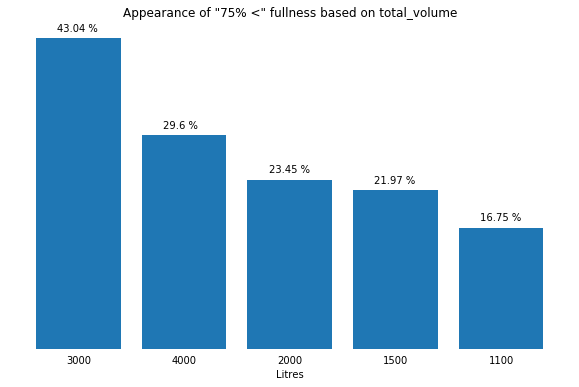

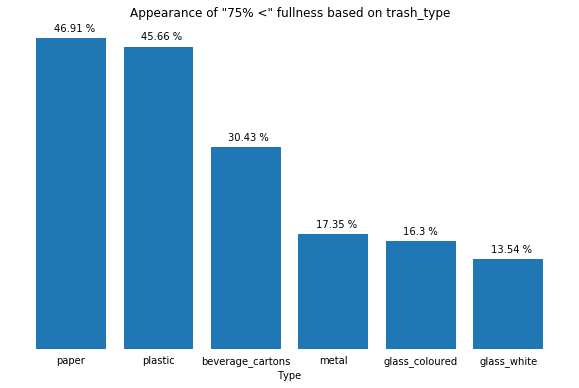

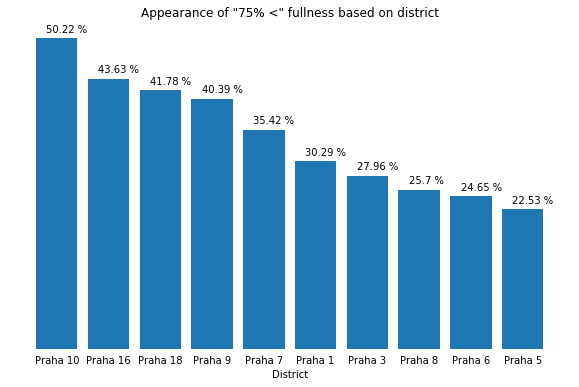

In [65]:
graf(procenta_typ_velikost,'75%<_count_in%','Litres')

graf(procenta_typ_odpadu,'75%<_count_in%','Type')

graf(procenta_ctvrt,'75%<_count_in%','District')

### Nyní budeme analyzovat skutečný stav zaznamenaný při svozu odpadu, jehož údaje máme ve třetí tabulce

In [48]:
# Vytvoříme si tři kategorie svozu a to na základě procenta uvedeného před vysypáním. 1. je do 75% objemu a tak ji ještě není nutno vysypat
# 2. je mezi 75 a 95%, kdy je svoz nutný a 3. 95%+ charakterizuje přeplněný kontejner, který už měl být vyvezen
bins = [-1, 75, 95, 101]
names = ['Not necessary (<75%)','Ready to empty (75-95%)', 'Overdue (95%+)']
nutnost = svoz.copy()
nutnost['percent_before_binned']= pd.cut(nutnost['percent_before'],bins,labels=names)
dum = pd.get_dummies(nutnost['percent_before_binned'])
nutnost = pd.merge(left= nutnost, right = dum,left_index=True, right_index=True, how='left')


In [49]:
# Vytvoříme tabulku, která se bude skládat z konkrétního množství výše zmíněných kategorií pro každý kontejner a průměrné procentuální hodnoty
nutnost_pocet = nutnost.pivot_table(index='container_id', values = ['Not necessary (<75%)','Ready to empty (75-95%)', 'Overdue (95%+)'], aggfunc= sum )
nut_prumer = nutnost.pivot_table(index='container_id', values = ['percent_before'], aggfunc= np.mean)
nutnost_pocet = pd.merge(left= nutnost_pocet, right = nut_prumer,left_index=True, right_index=True, how='left')
nutnost_pocet.rename(columns={'percent_before':'average_percent_before'},inplace=True)
nutnost_pocet['average_percent_before'] = nutnost_pocet['average_percent_before'].apply(lambda x: round(x,2))
nutnost_pocet.head(4)

,Not necessary (<75%),Overdue (95%+),Ready to empty (75-95%),average_percent_before
container_id,,,,
29786,11,0,0,53.91
29787,11,0,0,58.91
29788,5,12,5,89.27
29789,39,11,11,69.25


In [50]:
# Zjistíme, která čtvrť ma nevětší procento zbytečného odvozu odpadů

pivot_nutnost_pocet = pd.merge(left= nutnost_pocet, right=kont[['trash_type','district']],left_index = True,right_index=True, how='left')
ctvrte_pivot_nutnost_pocet = pivot_nutnost_pocet.pivot_table(index='district', values = ['Not necessary (<75%)','Overdue (95%+)', 'Ready to empty (75-95%)'], aggfunc= sum)
ctvrte_pivot_nutnost_pocet['Total'] = ctvrte_pivot_nutnost_pocet.sum(axis=1)
ctvrte_pivot_nutnost_pocet['<75%_count_in%'] = round(((ctvrte_pivot_nutnost_pocet['Not necessary (<75%)']/ctvrte_pivot_nutnost_pocet['Total'])*100),2)
ctvrte_pivot_nutnost_pocet['75-95%_count_in%'] = round(((ctvrte_pivot_nutnost_pocet['Overdue (95%+)']/ctvrte_pivot_nutnost_pocet['Total'])*100),2)
ctvrte_pivot_nutnost_pocet['95%+_count_in%'] = round(((ctvrte_pivot_nutnost_pocet['Ready to empty (75-95%)']/ctvrte_pivot_nutnost_pocet['Total'])*100),2)
ctvrte_pivot_nutnost_pocet

# Zjistíme, která typ odpadů ma největší procento předčasných svozů
typ_pivot_nutnost_pocet = pivot_nutnost_pocet.pivot_table(index='trash_type', values = ['Not necessary (<75%)','Overdue (95%+)', 'Ready to empty (75-95%)'], aggfunc= sum)
typ_pivot_nutnost_pocet['Total'] = typ_pivot_nutnost_pocet.sum(axis=1)
typ_pivot_nutnost_pocet['<75%_count_in%'] = round(((typ_pivot_nutnost_pocet['Not necessary (<75%)']/typ_pivot_nutnost_pocet['Total'])*100),2)
typ_pivot_nutnost_pocet['75-95%_count_in%'] = round(((typ_pivot_nutnost_pocet['Overdue (95%+)']/typ_pivot_nutnost_pocet['Total'])*100),2)
typ_pivot_nutnost_pocet['95%+_count_in%'] = round(((typ_pivot_nutnost_pocet['Ready to empty (75-95%)']/typ_pivot_nutnost_pocet['Total'])*100),2)
typ_pivot_nutnost_pocet

,Not necessary (<75%),Overdue (95%+),Ready to empty (75-95%),Total,<75%_count_in%,75-95%_count_in%,95%+_count_in%
district,,,,,,,
Praha 1,1051.0,749.0,397.0,2197.0,47.84,34.09,18.07
Praha 10,139.0,151.0,61.0,351.0,39.60,43.02,17.38
Praha 16,395.0,58.0,91.0,544.0,72.61,10.66,16.73
Praha 18,28.0,43.0,17.0,88.0,31.82,48.86,19.32
Praha 3,956.0,761.0,222.0,1939.0,49.30,39.25,11.45
Praha 5,66.0,90.0,58.0,214.0,30.84,42.06,27.10
Praha 6,552.0,438.0,243.0,1233.0,44.77,35.52,19.71
Praha 7,123.0,137.0,56.0,316.0,38.92,43.35,17.72
Praha 8,611.0,101.0,112.0,824.0,74.15,12.26,13.59


,Not necessary (<75%),Overdue (95%+),Ready to empty (75-95%),Total,<75%_count_in%,75-95%_count_in%,95%+_count_in%
trash_type,,,,,,,
beverage_cartons,540.0,179.0,87.0,806.0,67.00,22.21,10.79
glass_coloured,685.0,131.0,73.0,889.0,77.05,14.74,8.21
glass_white,593.0,50.0,77.0,720.0,82.36,6.94,10.69
metal,326.0,30.0,26.0,382.0,85.34,7.85,6.81
paper,1308.0,1287.0,640.0,3235.0,40.43,39.78,19.78
plastic,1087.0,1042.0,489.0,2618.0,41.52,39.80,18.68


In [58]:
svoz_celkem_pocet = len(svoz)
oznaceni = ['Not necessary (<75%)','Overdue (95%+)', 'Ready to empty (75-95%)']
opaky = nutnost_pocet[oznaceni].sum(axis=0)
proc_svoz_nutnosti = [round((x/svoz_celkem_pocet)*100,2) for x in opaky]
print('Na základě všech měření při svozu můžeme říci, že {}% veškerého vysypávání odpadu je předběžných, jelikož kontejnery jsou zaplněné meně jak ze 75% a dalo by se tak počkat. {}% je v rámci mezí, naplněnost je 75-95% a {}% je pozdních, jelikož nádoby jsou již přeplněné'.format(*proc_svoz_nutnosti))

Na základě všech měření při svozu můžeme říci, že 52.47% veškerého vysypávání odpadu je předběžných, jelikož kontejnery jsou zaplněné meně jak ze 75% a dalo by se tak počkat. 31.43% je v rámci mezí, naplněnost je 75-95% a 16.09% je pozdních, jelikož nádoby jsou již přeplněné


In [54]:
# Nyní trochu poupravíme předchozí funkci pro vizualizaci grafů
def graf_svoz(tabulka, sloupek,nazev):
    fig, ax = plt.subplots(figsize=(12,8))
    p1 = ax.bar(height = tabulka[sloupek[0]], x = np.arange(len(tabulka.index)) + 0.75, color='g',label=sloupek[0])
    p2 = ax.bar(height = tabulka[sloupek[1]], x = np.arange(len(tabulka.index)) + 0.75, bottom=tabulka[sloupek[0]], color='b',label=sloupek[1])
    p3 = ax.bar(height = tabulka[sloupek[2]], x = np.arange(len(tabulka.index)) + 0.75, bottom= np.array(tabulka[sloupek[0]])+np.array(tabulka[sloupek[1]]), color='r', label=sloupek[2])
    ax.set_xticklabels(tabulka.index.tolist())
    ax.set_xticks(np.arange(len(tabulka.index))+0.75)
    ax.tick_params(bottom='off',top=False, left=False,right=False, labelleft=False)
    ax.set_title('Appearance of fullness based on ' + nazev)
    ax.set_xlabel('{}'.format(nazev))
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    for axis in [p1,p2,p3]:
        for bar in axis:
            w, h = bar.get_width(), bar.get_height()
            plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                     "{:.2f}".format(h), ha="center", 
                     va="center")
   
    plt.legend(loc='best',ncol=3, fontsize = 'small')                   
    plt.show()

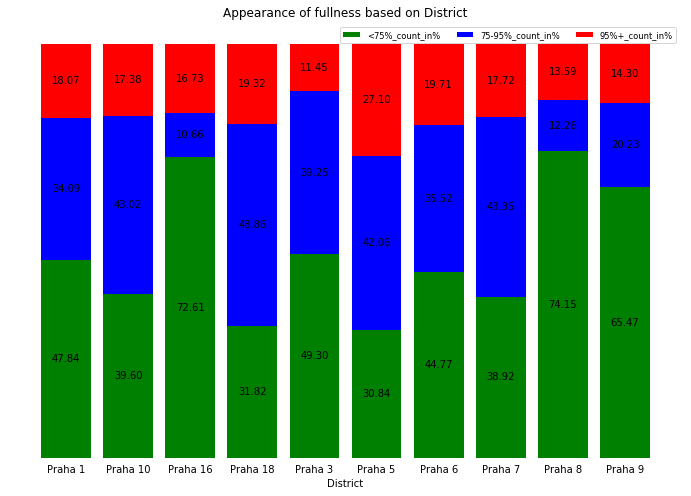

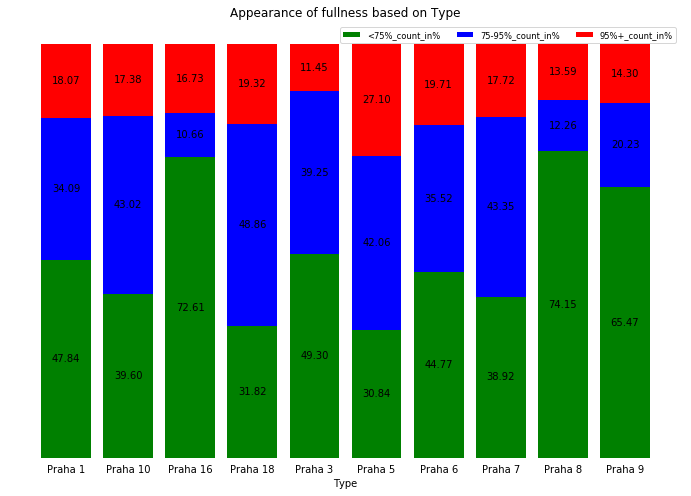

In [55]:
graf_svoz(ctvrte_pivot_nutnost_pocet, ['<75%_count_in%','75-95%_count_in%', '95%+_count_in%'], 'District')

graf_svoz(ctvrte_pivot_nutnost_pocet, ['<75%_count_in%','75-95%_count_in%', '95%+_count_in%'], 'Type')

In [56]:
# Finální tabulka, která porovná analytické tabulky vytvořené z "mer" a "svoz" a můžeme tak mít díky ní přehled a porovnání mezi skutečným stavem
# zaplněnosti popelnice při odovozu a četnosti přeplnění kontejneru
porovnani_svoz_mer = nutnost_pocet.copy()
porovnani_svoz_mer['Total'] = porovnani_svoz_mer[['Not necessary (<75%)','Overdue (95%+)', 'Ready to empty (75-95%)']].sum(axis=1)
porovnani_svoz_mer['Not necessary (<75%)'] = round(((porovnani_svoz_mer['Not necessary (<75%)']/porovnani_svoz_mer['Total'])*100),2)
porovnani_svoz_mer['Ready to empty (75-95%)'] = round(((porovnani_svoz_mer['Ready to empty (75-95%)']/porovnani_svoz_mer['Total'])*100),2)
porovnani_svoz_mer['Overdue (95%+)'] =round(((porovnani_svoz_mer['Overdue (95%+)']/porovnani_svoz_mer['Total'])*100),2)
porovnani_svoz_mer = pd.merge(left=porovnani_svoz_mer, right=cetnost_plnosti[['%_occurrence_of_>75%','fullness_average','total_volume','trash_type','district']],left_index=True,right_index=True,how='left')
porovnani_svoz_mer= porovnani_svoz_mer.sort_values('%_occurrence_of_>75%',ascending=False)

porovnani_svoz_mer.head(20)

,Not necessary (<75%),Overdue (95%+),Ready to empty (75-95%),average_percent_before,Total,%_occurrence_of_>75%,fullness_average,total_volume,trash_type,district
container_id,,,,,,,,,,
29793,0.00,100.00,0.00,100.00,2,98.53,98.97,3000,plastic,Praha 10
29834,0.00,100.00,0.00,100.00,2,96.02,97.44,3000,plastic,Praha 10
29974,16.67,16.67,66.67,79.67,6,93.85,87.16,3000,plastic,Praha 9
29932,25.00,65.00,10.00,77.35,20,88.28,90.37,3000,paper,Praha 1
29954,60.00,40.00,0.00,60.80,10,86.91,89.43,3000,paper,Praha 1
30162,50.00,25.00,25.00,69.50,4,85.17,89.10,3000,paper,Praha 8
29882,33.33,48.15,18.52,74.19,27,82.95,87.63,3000,paper,Praha 1
29835,16.67,83.33,0.00,91.25,12,82.41,88.73,3000,paper,Praha 10
29897,8.70,69.57,21.74,90.09,23,80.46,85.53,3000,paper,Praha 1


In [57]:
len(porovnani_svoz_mer.loc[(porovnani_svoz_mer['average_percent_before']>=75) & (porovnani_svoz_mer['fullness_average']>=75)])
len(nutnost_pocet)

33

409

### Při porovnání tabulek, které vznikly z průběžných měření "mer" a při svozech "svoz" nám vyplynulo, že 33 kontejnerů má v obou případech vysokou hodnotu nad 75% zaplněnosti objemu a tak by bylo  možné je svážet četněji. 10 nádob se do srovnání nedostalo, kvůli chybným údajům z tabulky "svoz"